In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, auc

In [2]:
# read data
csv_path = 'SignalPreiceDataSet.csv'
research_data = pd.read_csv(csv_path)

# Problem Description

This project aims to evaluate a data source that claims to have predictive power for future returns of the S&P 500 index, with SPY used as a proxy. The signal in the dataset is received at the end of each trading day, at the same time as the SPY closing price. We do not assume any specific forecast horizon over which the signal might be effective.

# Step 1: Exploratory Data Analysis and Feature Engineering

In [3]:
research_data.head()

,Date,Signal,ClosePrice
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


In [4]:
# We have three features: data, Signal and ClosePrice. 
# The scale of sinal close price is different, indicating scaling could be important 
# if we plan to build a model using the two features.

In [5]:
research_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        667 non-null    int64  
 1   Signal      667 non-null    float64
 2   ClosePrice  667 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 15.8 KB


In [6]:
# no missing data

In [7]:
# convert date from int Dtype to datetime
research_data['Date'] = pd.to_datetime(research_data["Date"], format="%Y%m%d")

In [8]:
research_data.describe()

,Date,Signal,ClosePrice
count,667,667.000000,667.000000
mean,2013-05-03 21:50:27.886056960,5.166603,163.169369
min,2012-01-03 00:00:00,-3.802670,127.495000
25%,2012-08-29 12:00:00,3.418083,140.880000
50%,2013-05-08 00:00:00,3.893689,159.750000
75%,2014-01-01 12:00:00,4.408313,181.500000
max,2014-08-29 00:00:00,432.961165,710.310000
std,NaN,23.392818,39.210384


In [9]:
# The std of signal is large considring most of its values are distributed arond -3.8 to 4.4.
# The max of signal = 432 is much larger than its mean 5 and min -3.8.
# Both suggest presence of (potentially) outliers or heavy right tail. 

# The std of ClosePrice looks fine, but its max value is still worrying.

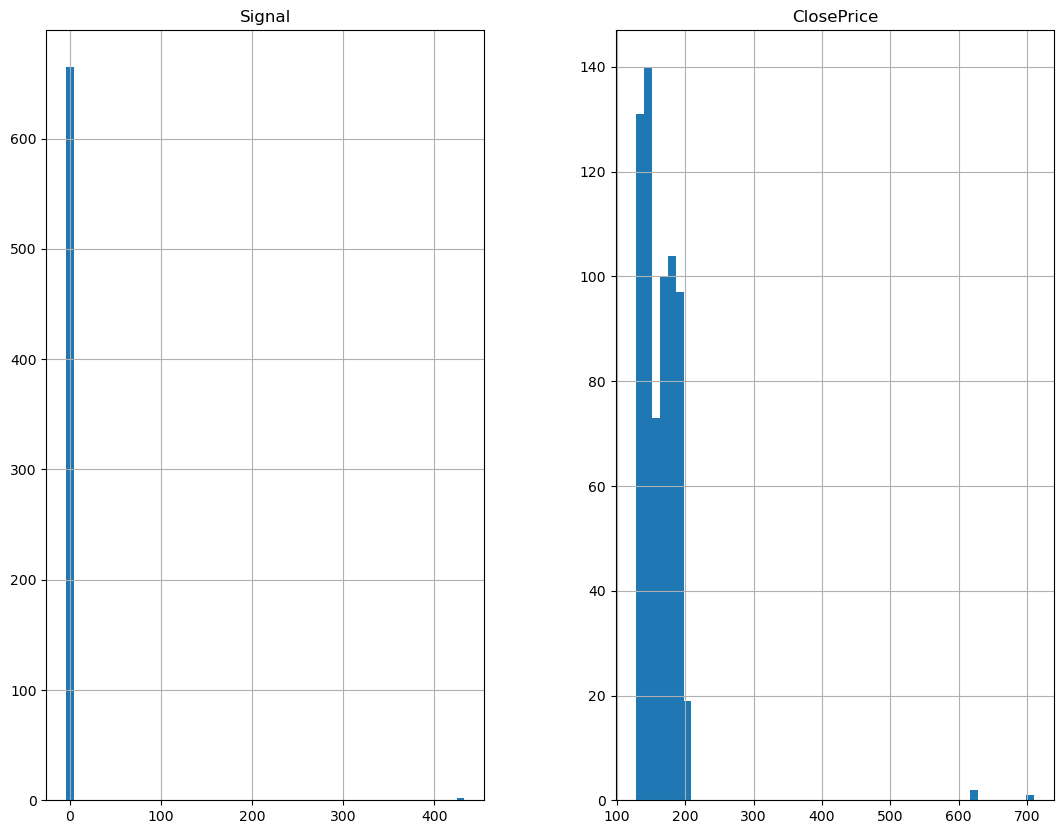

In [10]:
features = ['Signal', 'ClosePrice']
research_data[features].hist(bins = 50, figsize=(13,10))
plt.show()

In [11]:
# We can clearly see outliers present in both features,
# we will remove the outliers for both features.

In [12]:
# remove outliers and check the distributions agian
research_data_outliers_removed = research_data[research_data['Signal'] < 50]
research_data_outliers_removed = research_data_outliers_removed[research_data_outliers_removed['ClosePrice'] < 300]

In [13]:
research_data_outliers_removed.describe()

,Date,Signal,ClosePrice
count,662,662.000000,662.000000
mean,2013-05-02 17:56:44.229607424,3.883968,160.924379
min,2012-01-03 00:00:00,-3.802670,127.495000
25%,2012-08-28 06:00:00,3.417354,140.842500
50%,2013-05-04 12:00:00,3.876578,159.350000
75%,2014-01-02 18:00:00,4.406493,181.330000
max,2014-08-29 00:00:00,4.881311,200.710000
std,NaN,0.650370,21.482816


In [14]:
# the std for both features looks much better now!

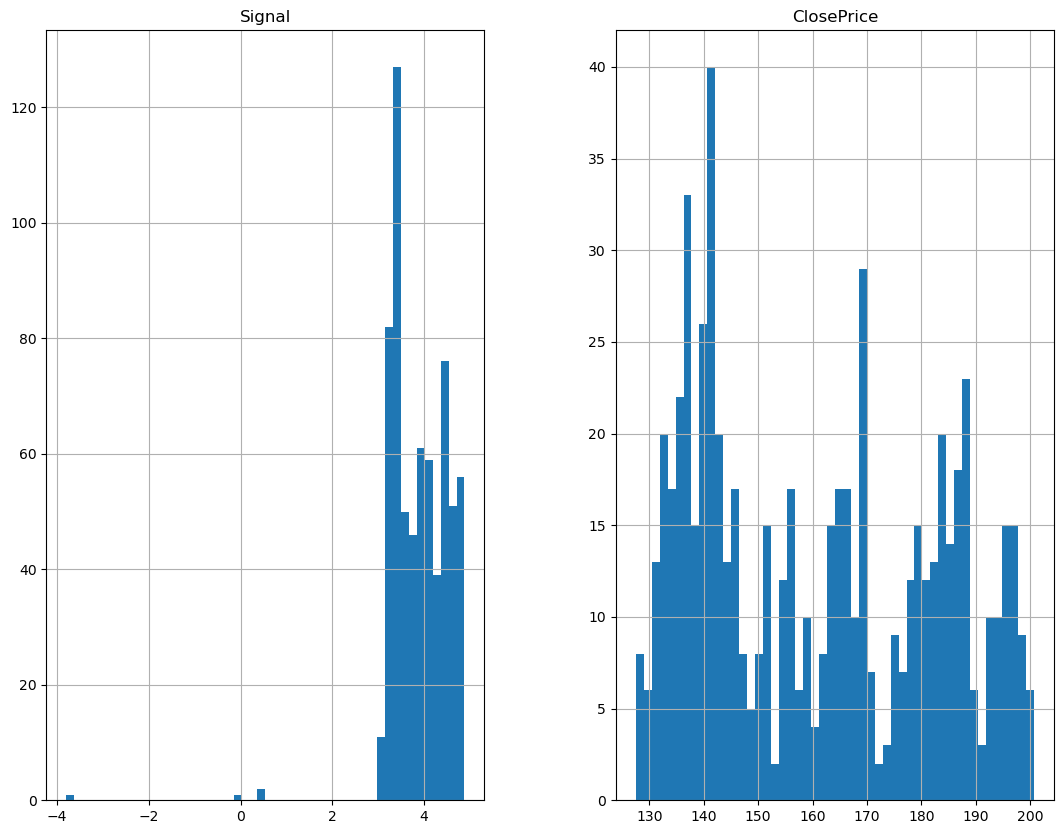

In [15]:
research_data_outliers_removed[features].hist(bins = 50, figsize=(13,10))
plt.show()

In [16]:
# there seems to be extra outliers in signal, and
# both distributions are highly unnormal distributed

In [17]:
# let us remove the extra outliers in signal  
research_data_outliers_removed = research_data_outliers_removed[research_data_outliers_removed['Signal'] > 2]

In [18]:
research_data_outliers_removed.describe()

,Date,Signal,ClosePrice
count,658,658.000000,658.000000
mean,2013-05-01 05:19:30.820668672,3.911967,160.824444
min,2012-01-03 00:00:00,3.099757,127.495000
25%,2012-08-27 06:00:00,3.419053,140.817500
50%,2013-05-02 12:00:00,3.890291,159.245000
75%,2013-12-31 18:00:00,4.409072,180.985000
max,2014-08-29 00:00:00,4.881311,200.710000
std,NaN,0.525500,21.488326


In [19]:
# recall that we have 667 samples at the begining, after removing all outliers,
# 658 leaves, so we delete 9 samples in total.

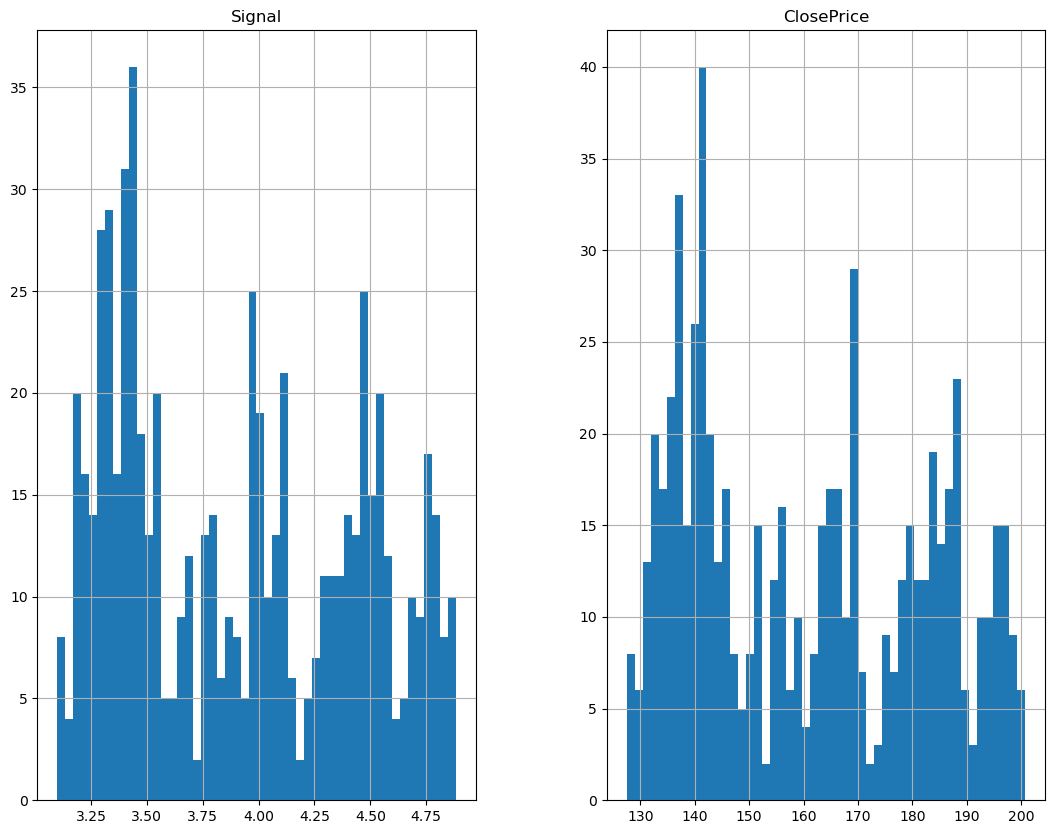

In [20]:
research_data_outliers_removed[features].hist(bins = 50, figsize=(13,10))
plt.show()

In [21]:
# after removing all outliers, we can see the distribution shapes between the Signal 
# and ClosePrice look very similar, also both are highly unnormal distributed.

In [22]:
# Before we proceed for more data analysis, we want to create a test dataset, 
# for evaluting the predictive power of the signal
research_data_outliers_removed.sort_values(by='Date', ascending=True, inplace=True) # Make sure the data is ordered according to date
training_ratio = 0.9
split_index = int(research_data_outliers_removed.shape[0] * training_ratio)
training_data = research_data_outliers_removed[:split_index]
testing_data = research_data_outliers_removed[split_index:]

In [23]:
# check the training and testing data shape
print('training data shpe:', training_data.shape)
print('testing data shpe:', testing_data.shape)

training data shpe: (592, 3)
testing data shpe: (66, 3)


<Axes: xlabel='Signal', ylabel='ClosePrice'>

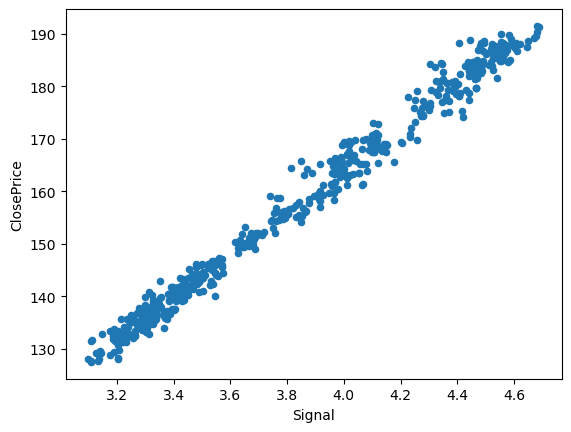

In [24]:
# lets check the scatterplot between signal and ClosePrice
training_data.plot(kind = 'scatter', x = 'Signal', y = 'ClosePrice')

In [25]:
# this looks highly positive correlated! (This would be encouraging if we are not dealing with time series data). 
# However, remember the signal and the closePrice are
# both received at the end of the day. So actually in order to test the predictive power
# of the signal, we have to use the signal BEFORE the closePrice to do prediction

In [26]:
# now we want to see how the two features change over time,
# to do so, let us first scale the two features
std_scale = StandardScaler()
scaled_training_data = training_data.copy()
scaled_training_data[features] = std_scale.fit_transform(training_data[features])

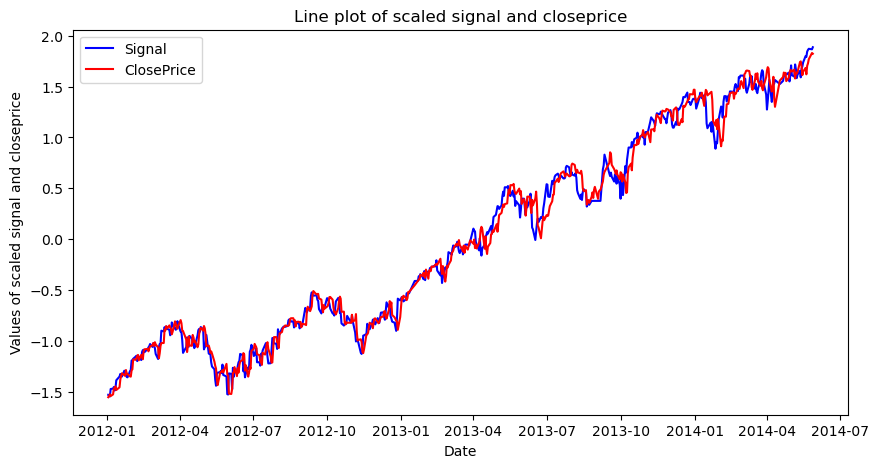

In [27]:
# plot the two features over time
plt.figure(figsize=(10, 5))  # Set figure size
# Plot both lines on the same axes
plt.plot(scaled_training_data["Date"], scaled_training_data["Signal"], color="blue", label="Signal")
plt.plot(scaled_training_data["Date"], scaled_training_data["ClosePrice"], color="red", label="ClosePrice")
# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Values of scaled signal and closeprice")
plt.title("Line plot of scaled signal and closeprice")
plt.legend()
# Show the plot
plt.show()


In [28]:
# This figure confirms the high correlation between signal and ClosePrice, 
# as we found before.

### Interpret the line plot of the signal and ClosePrice


1. If we take a closer look at the figure, the signal seems to be a very good predictor for the ClosePrice, since the ClosePrice appears to follow
a similar pattern as the signal. Consider the lowest point around 2013-07, for example, the Signal seems to correctly predict that the ClosePrice will dip to the lowest and then bound up quickly.
2. There seems to be a shift of the time lag of the signal to be predictive. According to the figure, we might use signal change 1 or 2 two days ago to predict price change before 2013-04, but after that, we might want to use larger time lag, for example 5 days old signal chane to predict the price change.

In [29]:
# We have analyzed the price itself, and find some interesting patterns.
# However, remember that our task is to evaluate the predictive power of the sigal, 
# For this purpose, we should work on the returns of the price, rather than the price itself.

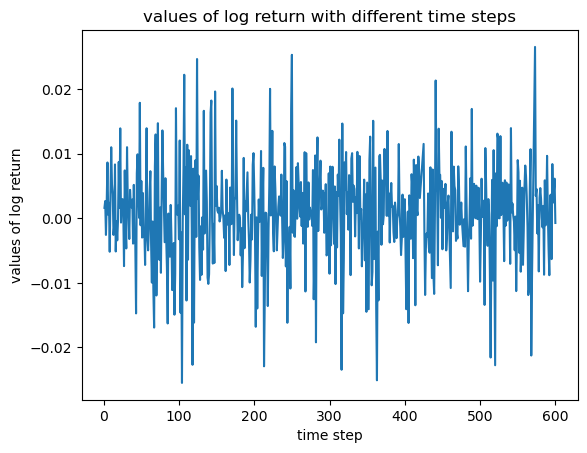

return mean:  0.0006872822879997728
return var:  5.7952642131551006e-05


In [30]:
return_training_data = np.log(training_data["ClosePrice"]).diff().dropna() # compute log return
return_training_data.plot()
plt.xlabel('time step') 
plt.ylabel('values of log return') 
plt.title('values of log return with different time steps')
plt.show()
print('return mean: ', np.mean(return_training_data))
print('return var: ', np.var(return_training_data))

<Axes: >

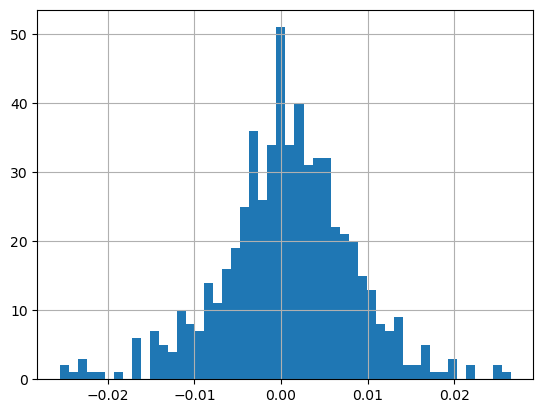

In [31]:
# check the distribution of the log return
return_training_data.hist(bins=50)

<Figure size 800x500 with 0 Axes>

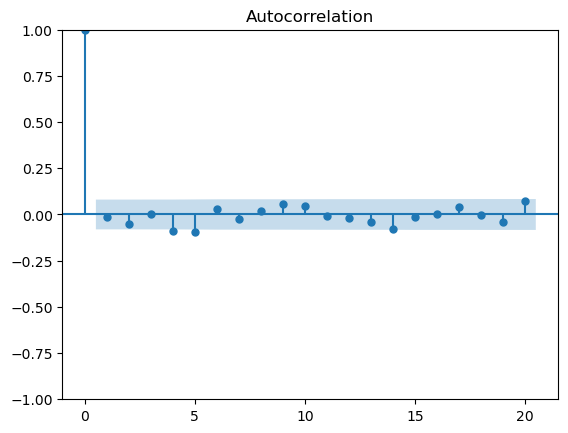

In [32]:
# consider the acf of return
plt.figure(figsize=(8,5))
plot_acf(return_training_data, lags=20) 
plt.show()

In [33]:
# the return looks quite random with autocorrelation coefficients close to 0.

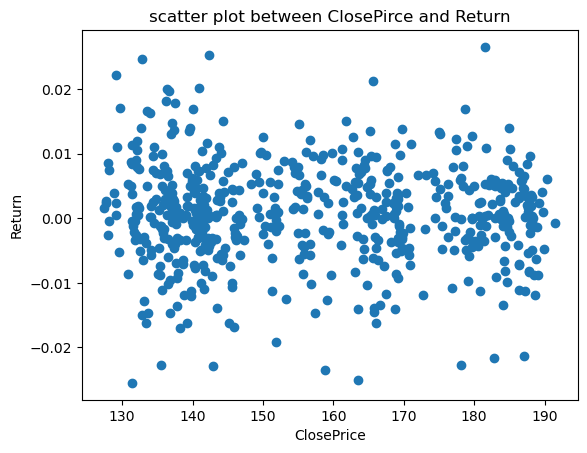

In [34]:
# now we check if the ClosePrice or signal is correlated to the returns
plt.scatter(training_data['ClosePrice'][:-1], return_training_data)
plt.xlabel('ClosePrice')
plt.ylabel('Return')
plt.title('scatter plot between ClosePirce and Return')
plt.show()

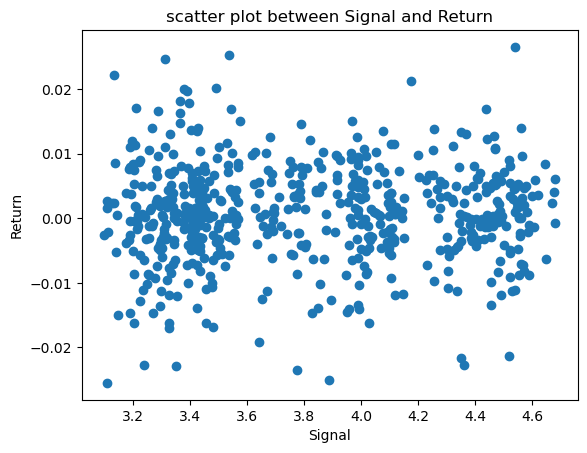

In [35]:
plt.scatter(training_data['Signal'][:-1], return_training_data)
plt.xlabel('Signal')
plt.ylabel('Return')
plt.title('scatter plot between Signal and Return')
plt.show()

In [36]:
# so we didnt find useful pattern from two figures above. 

In [37]:
# let us, however, consider if the signal_change_ratio is correlated to the return
signal_change_ratio = np.log(training_data["Signal"]).diff().dropna()

In [38]:
# Check the correlation between signal_change_ratio and return_training_data with different lag k 
res_cor = []
lag_range = [i for i in range(1,20)]
for lag in lag_range:
    correlation = np.corrcoef(signal_change_ratio[:-lag], return_training_data[lag:])[0,1]
    res_cor.append(correlation)


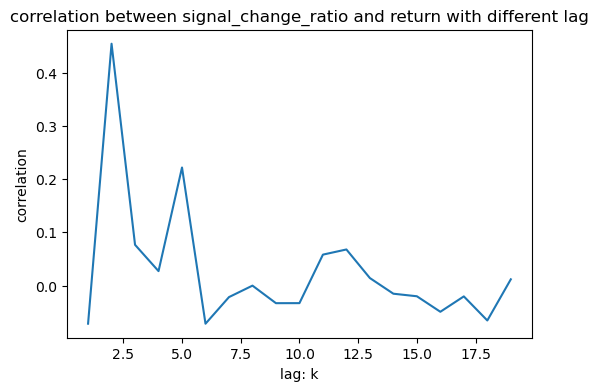

In [39]:
plt.figure(figsize=(6,4))
plt.plot(lag_range, res_cor)
plt.xlabel('lag: k')
plt.ylabel('correlation')
plt.title('correlation between signal_change_ratio and return with different lag')
plt.show()

In [40]:
# Amazing! So signal_change_ratio is highly correlated signal_change_ratio.
# This confirms our guess before that the signal is a very strong predictor for the price.

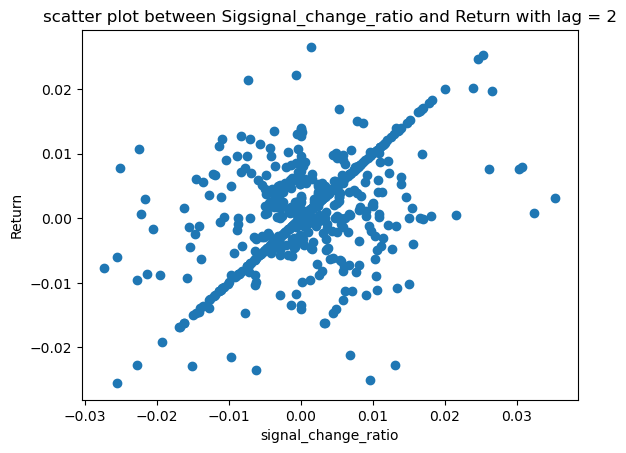

In [41]:
# Lets take a look how the plot looks like when time lag k = 2
plt.scatter(signal_change_ratio[:-2], return_training_data[2:])
plt.xlabel('signal_change_ratio')
plt.ylabel('Return')
plt.title('scatter plot between Sigsignal_change_ratio and Return with lag = 2')
plt.show()

This plot suggests a subset of signal change ratio points are highly linearly correlated to the returns, as shown by lying
in the diagnoal line, but some looks quite random. 

Lets not forget the analysis we did before. Remember that the time lag for the signal change ratio to be predictive
could shift with time. One guess is that before 2013-04, the return is highly correlated to signal change ratio with time lag = 2,
but after that signal change ratio with different time lags would be more correlated, e.g. 5.


In [42]:
training_data.index[training_data['Date'] == '2013-04-01'] # check the index of the date

Index([306], dtype='int64')

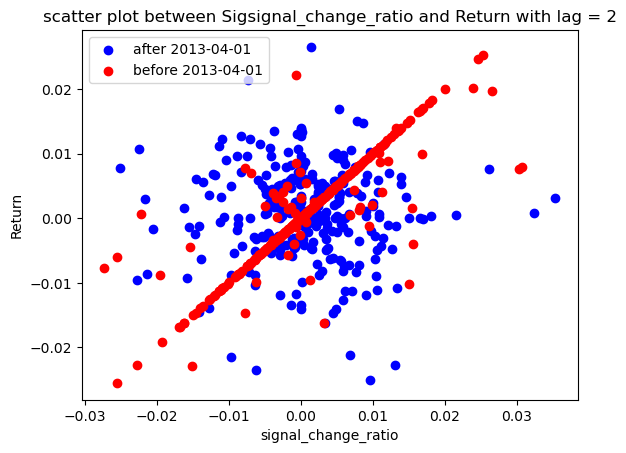

In [43]:
# lets verify our guess: with time lag = 2
tau = 306
plt.scatter(signal_change_ratio[:-2].iloc[tau:], return_training_data[2:][tau:], c="blue", label = 'after 2013-04-01')
plt.scatter(signal_change_ratio[:-2].iloc[:tau], return_training_data[2:][:tau], c="red", label = 'before 2013-04-01')
plt.xlabel('signal_change_ratio')
plt.ylabel('Return')
plt.title('scatter plot between Sigsignal_change_ratio and Return with lag = 2')
plt.legend()
plt.show()

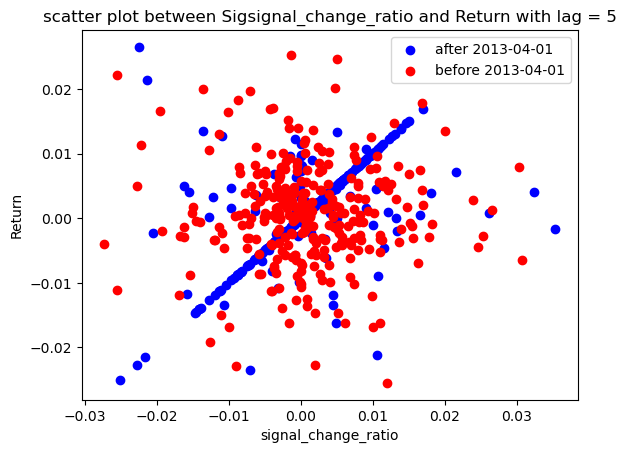

In [44]:
# lets verify our guess: with time lag = 5
tau = 306
plt.scatter(signal_change_ratio[:-5].iloc[tau:], return_training_data[5:][tau:], c="blue", label = 'after 2013-04-01')
plt.scatter(signal_change_ratio[:-5].iloc[:tau], return_training_data[5:][:tau], c="red", label = 'before 2013-04-01')
plt.xlabel('signal_change_ratio')
plt.ylabel('Return')
plt.title('scatter plot between Sigsignal_change_ratio and Return with lag = 5')
plt.legend()
plt.show()

In [45]:
# The above two figures confirm our guess.

In [46]:
# Now we evalute whether the signal has predictive power of the return.
# Given the strong correlation between signal change ratio and return,
# we are confident that the signal has good predictive power.
# To further confirm this point, we use the signal to predict the direction 
# of the return, i.e. + or -, and see if it can works
# better than random guess.

# Step 2: Process Data for Binary Classification

In [47]:
data = pd.concat((training_data, testing_data))
X = data['Signal']
y = data['ClosePrice']
signal_change_ratio = np.log(X).diff().dropna()
return_data = np.log(y).diff().dropna()
return_data = (return_data > 0).astype(int) # since we are considering binary classification problem, we only care about > 0 or < 0

In [48]:
def sliding_window(data_X, data_y, k):
    # k: sliding window size
    X, y = [], []
    data_X = np.array(data_X)
    data_y = np.array(data_y)
    for i in range(k, len(data_X)):
        X.append(data_X[i-k:i])  # Create features with the previous `k` values
        y.append(data_y[i])      # Target is the next value, make sure it is not included in X

    return np.array(X), np.array(y)

In [49]:
X, y = sliding_window(signal_change_ratio, return_data, 5)
# we choose window length = 5 here since the 
# signal_change_ratio is highly correlated signal_change_ratio when time lag = 2 and 5

In [50]:
# recall that we decided to use last 10% for testing
testing_ratio = 0.1
# let us use 10% for validation as well
validation_ratio = 0.1

X_training, y_training = X[0:int(0.8*len(X))], y[0:int(0.8*len(X))]
X_validation, y_validation = X[int(0.8*len(X)):int(0.9*len(X))], y[int(0.8*len(X)):int(0.9*len(X))]
X_testing, y_testing = X[int(0.9*len(X)):], y[int(0.9*len(X)):]

In [51]:
# lets make sure the shape is correct
print('X_training shape:', X_training.shape)
print('y_training shape:', y_training.shape)
print('X_validation shape:', X_validation.shape)
print('y_validation shape:', y_validation.shape)
print('X_testing shape:', X_testing.shape)
print('y_testing shape:', y_testing.shape)

X_training shape: (521, 5)
y_training shape: (521,)
X_validation shape: (65, 5)
y_validation shape: (65,)
X_testing shape: (66, 5)
y_testing shape: (66,)


In [52]:
# reshape the data
y_training = y_training.reshape(-1,1)
y_validation = y_validation.reshape(-1,1)
y_testing = y_testing.reshape(-1,1)

# Step 3: Build Models

### Logistic Regression

In [54]:
# model_logistic_1: use the last 5 time steps of signal change ratio as predictors. 
model_logistic_1 = LogisticRegression()
# Fit the model on training data
model_logistic_1.fit(X_training, y_training)
y_prob = model_logistic_1.predict_proba(X_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)


/opt/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


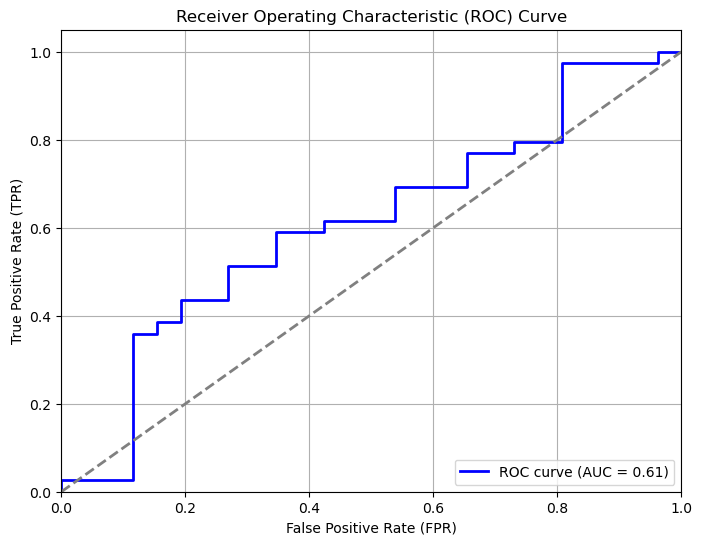

In [55]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [56]:
# AUC is 0.61, it is better than nothing (random guess should be around 0.5)!
# but we can potentially do better, remember features inlcudes all 5 last timesteps of signal_change_ratio.
# Maybe it is not necessary, especially that we only care about prediction, contrasting to imputation.
# Recall that after 2013-04, time lag = 5 is more correlated to
# return and other time lag may not be as important,
# so lets try some other combs of timesteps. 

# time lag = 5 only
X_training_version_1 = X_training[:,0].reshape(-1,1) 
X_validation_version_1 = X_validation[:,0].reshape(-1,1) 
X_testing_version_1 = X_testing[:,0].reshape(-1,1) 

# time lag = 2 only
X_training_version_2 = X_training[:,4].reshape(-1,1) 
X_validation_version_2 = X_validation[:,4].reshape(-1,1) 
X_testing_version_2 = X_testing[:,4].reshape(-1,1) 

# step 2 and step 5
X_training_version_3 = np.hstack((X_training[:,0].reshape(-1,1), X_training[:,4].reshape(-1,1)))
X_validation_version_3 = np.hstack((X_validation[:,0].reshape(-1,1), X_validation[:,4].reshape(-1,1)))
X_testing_version_3 = np.hstack((X_testing[:,0].reshape(-1,1), X_testing[:,4].reshape(-1,1)))

In [57]:
# model_logistic_2: use signal change ratio with time lag = 5 as predictors. 
model_logistic_2 = LogisticRegression()
# Fit the model on training data
model_logistic_2.fit(X_training_version_1, y_training)
y_prob = model_logistic_2.predict_proba(X_validation_version_1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)


/opt/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


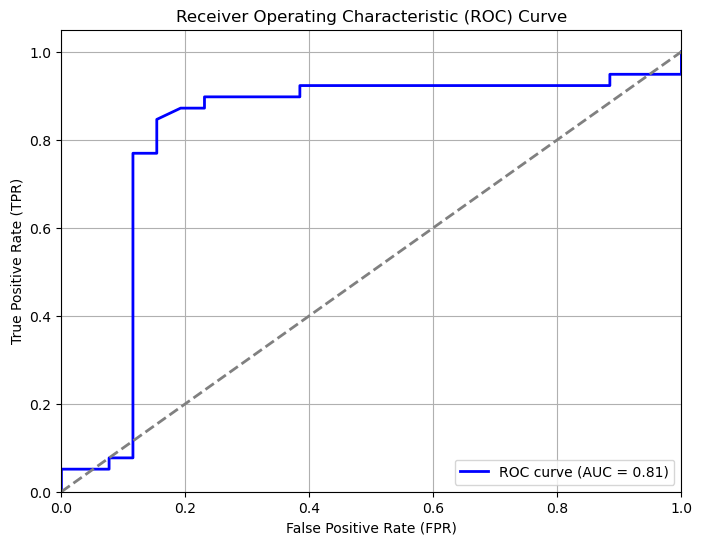

In [58]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [59]:
# model_logistic_2: use signal change ratio with time lag = 2 as predictors. 

model_logistic_3 = LogisticRegression()
# Fit the model on training data
model_logistic_3.fit(X_training_version_2, y_training)
y_prob = model_logistic_3.predict_proba(X_validation_version_2)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

/opt/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


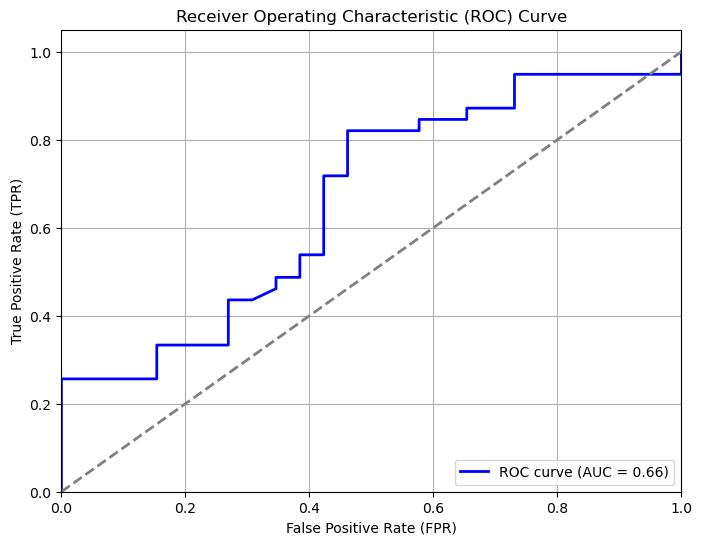

In [60]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [61]:
# model_logistic_4: use signal change ratio with time lag = 2 and time lag = 5 as predictors. 

model_logistic_4 = LogisticRegression()
# Fit the model on training data
model_logistic_4.fit(X_training_version_3, y_training)
y_prob = model_logistic_4.predict_proba(X_validation_version_3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

/opt/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
print("Coefficients:", model_logistic_4.coef_)
# if we use signal change ratio with time lag = 5 and time lag = 2, we can see that time lag = 5 is much 
# more important than time lag = 2 in the logistic model, which further confirms our guess.

Coefficients: [[ 0.4185837  -0.01713992]]


In [65]:
# logistic regression explores the linear relationship between x and y, and has shown good results on validation data.
# It's time to explore more complex model to see if we can capture any more non-linear relationships.

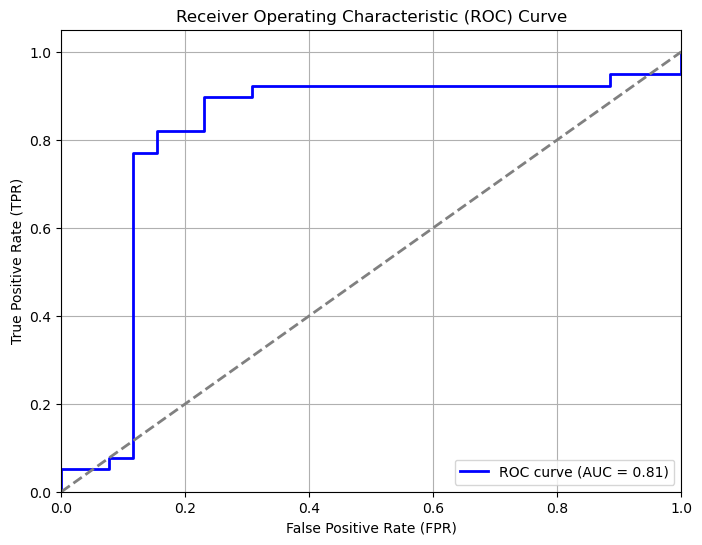

In [62]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Random Forest

In [ ]:
# model_rf_1: use the last 5 time steps of signal change ratio as predictors. 

tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=200)
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [2, 3, 5, 10],  # Maximum depth of trees
    'min_samples_split': [20, 30, 50, 70, 100],  # Minimum samples to split a node
    'min_samples_leaf': [20, 30, 50, 70, 100],    # Minimum samples in a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_training, y_training)

# Best parameters and model
print(f"Best Hyperparameters: {grid_search.best_params_}")
model_rf_1 = grid_search.best_estimator_

# time lag = 1,2,3,4,5
y_prob = model_rf_1.predict_proba(X_validation)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

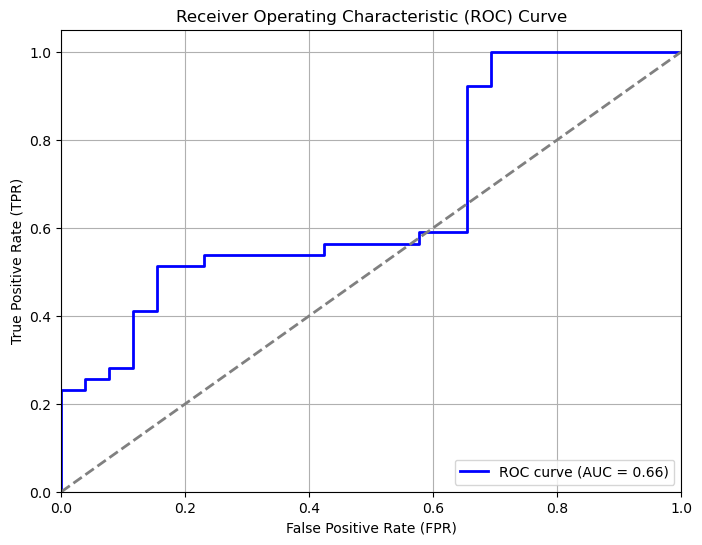

In [64]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# model_rf_2: use signal change ratio with time lag = 5 as predictors. 
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators = 200)
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [2, 3, 5, 10],  # Maximum depth of trees
    'min_samples_split': [20, 30, 50, 70, 100],  # Minimum samples to split a node
    'min_samples_leaf': [20, 30, 50, 70, 100],    # Minimum samples in a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_training_version_1, y_training)

# Best parameters and model
print(f"Best Hyperparameters: {grid_search.best_params_}")
model_rf_2 = grid_search.best_estimator_

y_prob = model_rf_2.predict_proba(X_validation_version_1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)


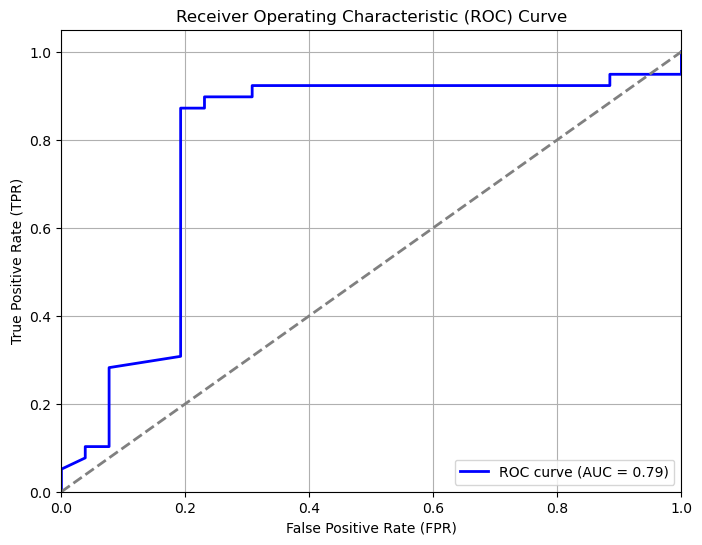

In [66]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# model_rf_3: use signal change ratio with time lag = 2 as predictors. 
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators = 200)
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [2, 3, 5, 10],  # Maximum depth of trees
    'min_samples_split': [20, 30, 50, 70, 100],  # Minimum samples to split a node
    'min_samples_leaf': [20, 30, 50, 70, 100],    # Minimum samples in a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_training_version_2, y_training)

# Best parameters and model
print(f"Best Hyperparameters: {grid_search.best_params_}")
model_rf_3 = grid_search.best_estimator_

y_prob = model_rf_3.predict_proba(X_validation_version_2)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)



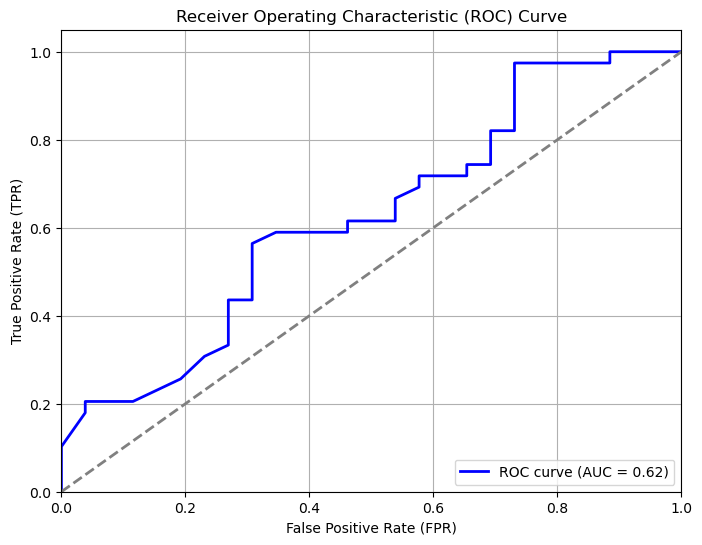

In [68]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# model_rf_4: use signal change ratio with time lag = 2 and time lag = 5 as predictors. 
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators = 200)
# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [2, 3, 5, 10],  # Maximum depth of trees
    'min_samples_split': [20, 30, 50, 70, 100],  # Minimum samples to split a node
    'min_samples_leaf': [20, 30, 50, 70, 100],    # Minimum samples in a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_training_version_3, y_training)

# Best parameters and model
print(f"Best Hyperparameters: {grid_search.best_params_}")
model_rf_4 = grid_search.best_estimator_

y_prob = model_rf_4.predict_proba(X_validation_version_3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)


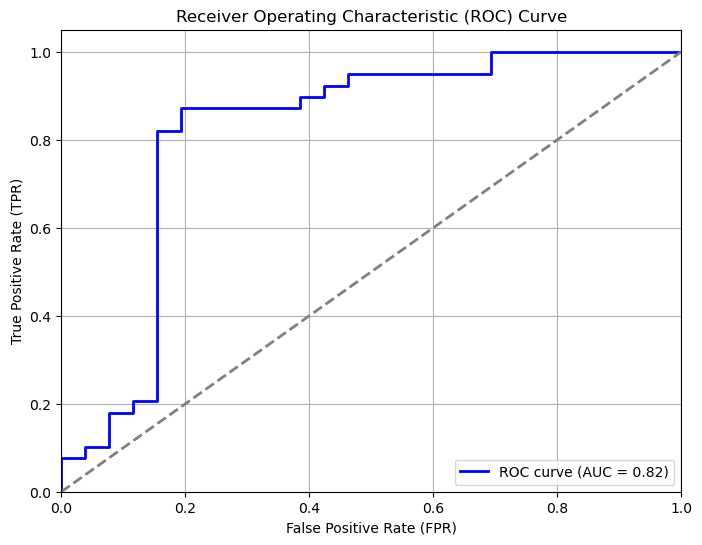

In [70]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [70]:
# so the random forest has almost the same performance on validation test set if signal change ratio when
# only time lag = 2 or time lag = 2 and 5 are both feeded as training features.
# This suggests that random forest might not extract much more information than logistic regression.
# So the signal change ratio is very likely to only linearly correlated to return after all.

# Model Analysis

In this project, we consider two models: logistic regression and random forest. We test both models with different combination of features. The two models both achieve AUC scores around 0.82.

We might be interested in how to set the threshold. The answer depends on how much risk (i.e. FPR, the probability of making false positive prediction) we can take. As we can see from the ROC curve, the model makes more true positive prediction if we are taking higher risk.

0.2 might be a good FPR, since at this point, the model has more than 80% chance to make true positive prediction, and the gain by further increasing FPR is not significant.

In [71]:
# consider logistic regression
# set threshold to achieve FPR close to 0.2. 
# Predict the labels for the validation set
y_prob_logistic = model_logistic_2.predict_proba(X_validation_version_1)[:, 1]

fpr, tpr, thresholds = roc_curve(y_validation, y_prob_logistic)
# Find the threshold where FPR is closest to 0.2
idx = np.argmax(fpr - 0.2 >= 0)  # Find index where FPR is closest to 0.2

optimal_threshold_logistic = thresholds[idx]
y_pred = (y_prob_logistic >= optimal_threshold_logistic).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_validation, y_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Compute Accuracy
accuracy = accuracy_score(y_validation, y_pred)
# Compute Recall
recall = recall_score(y_validation, y_pred)
# Compute Precision
precision = precision_score(y_validation, y_pred)
# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Confusion Matrix:
[[20  6]
 [ 5 34]]
Accuracy: 0.8308
Recall: 0.8718
Precision: 0.8500


In [72]:
# finally, let's test this model on testing data using the trained model,
# and the threshold we calculated above

# Predict the labels for the validation set
y_prob = model_logistic_2.predict_proba(X_testing_version_1)[:, 1]
y_pred = (y_prob >= optimal_threshold_logistic).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_testing, y_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Compute Accuracy
accuracy = accuracy_score(y_testing, y_pred)
# Compute Recall
recall = recall_score(y_testing, y_pred)
# Compute Precision
precision = precision_score(y_testing, y_pred)
# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Confusion Matrix:
[[23  2]
 [ 3 38]]
Accuracy: 0.9242
Recall: 0.9268
Precision: 0.9500


# Conclusion

We analyze the data and found out that the singal change is highly correlated to the return (price change), suggesting that the signal is a strong predictor of the returns. To further verify this, we used the signal to predict the direction of the return for the next day, i.e. whether the return will be positive or negative, and achieve impressive results on testing data, with around 92% accuracy and AUC score 0.82. The results suggest that the signal has good potential for predicting the values of price change, although this is not persued directly in this project.

Our main concern for this signal is that the dependency between the signal and the return appears to change over time, according to our analysis using the given dataset. This could degrade the performance of a trained model in the long run. To address this, we suggest to continusouly monitoring the model performance and retrain the model if the performance dropped too much. Alternatively, we could develop a stragety to enable the model to learn the change pattern in the data.